In [1]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%tensorflow_version 2.x 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import json
from glob import glob
from PIL import Image
import pickle
import keras
import warnings

import sys, time, os, warnings 

from tqdm import tqdm

from collections import Counter 
from nltk.translate.bleu_score import sentence_bleu

import seaborn as sns

from tensorflow.keras.preprocessing.image import load_img, img_to_array

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/MyDrive/DLProject')

In [5]:
!unzip Images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844747252_64567cf14a.jpg  
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b57211

In [6]:
images_path = '/content/drive/MyDrive/DLProject/Images/'
captions_path = '/content/drive/MyDrive/DLProject/Flickr8k.token.txt'

total_images = os.listdir(images_path)
print("Total Number of images: {}".format(len(total_images)))

Total Number of images: 8091


In [7]:
file = open(captions_path, 'r')
text = file.read()
file.close()

rows = text.split('\n')
data = []
for row in rows:
    if row:
        file_caption = row.split('\t')
        if len(file_caption) == 1:
          continue
        filename_index = file_caption[0]
        index_list = filename_index.split('#')
        data.append((index_list[0], index_list[1], file_caption[1]))

images_data = pd.DataFrame(data, columns=['filename', 'index', 'captions'])
print(images_data.head())

unique_files = np.unique(images_data.filename.values)
print("Total images : {}".format(len(unique_files)))
Counter(Counter(images_data.filename.values).values())

                    filename index  \
0  1000268201_693b08cb0e.jpg     0   
1  1000268201_693b08cb0e.jpg     1   
2  1000268201_693b08cb0e.jpg     2   
3  1000268201_693b08cb0e.jpg     3   
4  1000268201_693b08cb0e.jpg     4   

                                            captions  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...  
Total images : 8091


Counter({5: 8091})

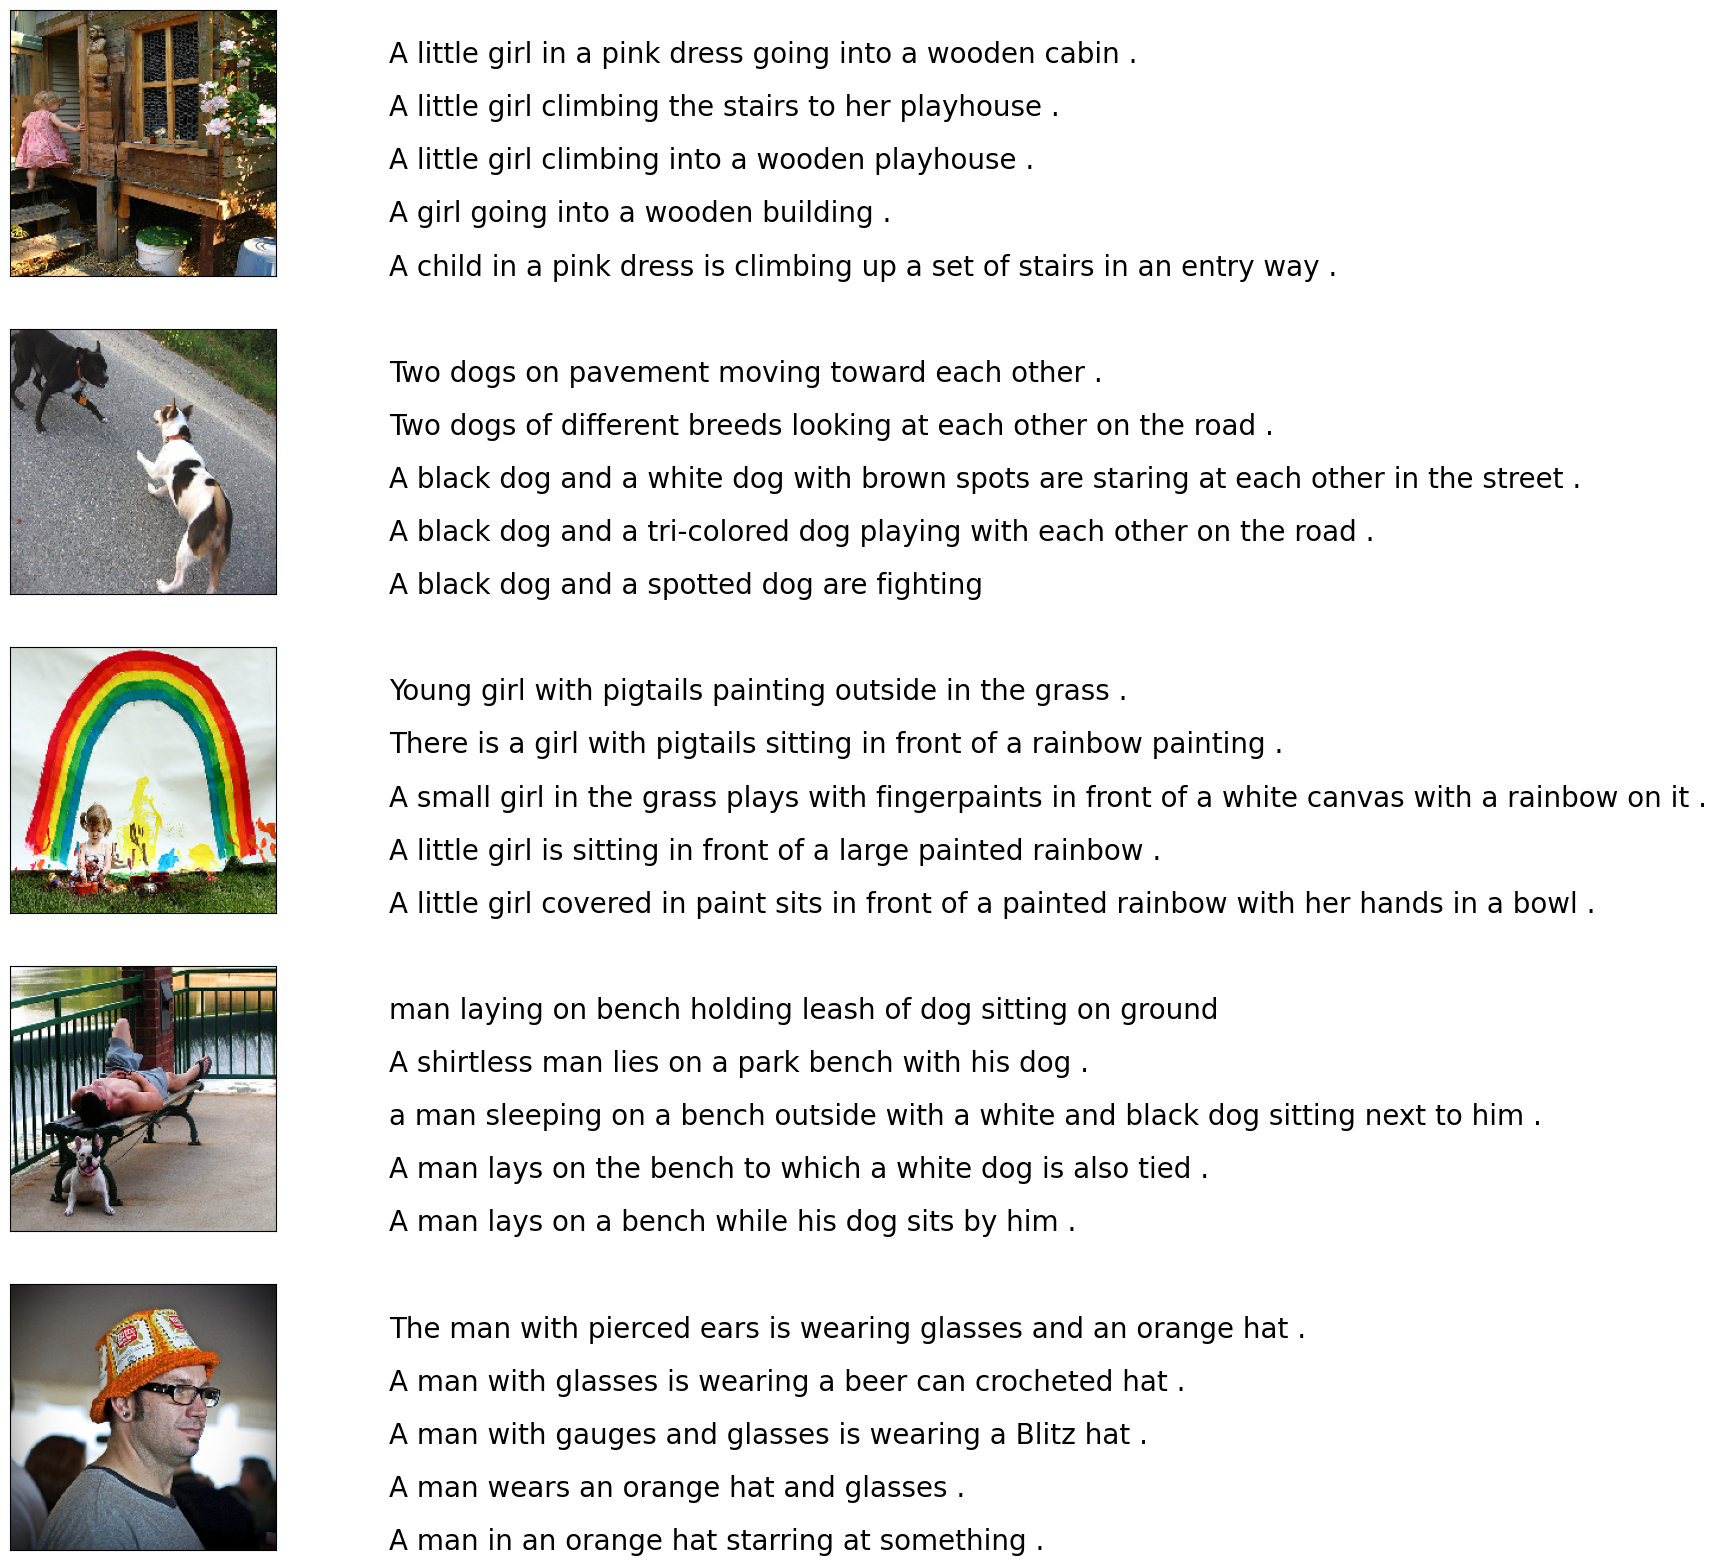

In [8]:
pic = 5
pixel = 224
target_size = (pixel,pixel,3)

count = 1
fig = plt.figure(figsize=(10,20))
for fl in unique_files[:pic]:
    filename = images_path + '/' + fl
    captions = list(images_data["captions"].loc[images_data["filename"]==fl].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(pic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(pic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [9]:
def vocabulary(df_txt):
  vocab = []
  for txt in df_txt.captions.values:
    vocab.extend(txt.split())
  print('Total words in vocabulary: %d' % len(set(vocab)))
  ct = Counter(vocab)
  word_data = pd.DataFrame.from_dict(ct, orient='index').sort_values(by=0, ascending=False)
  word_data = word_data.reset_index()
  word_data = word_data.rename({'index':'word',0:'count'}, axis=1)
  return(word_data)

word_data = vocabulary(images_data)
word_data.head()

Total words in vocabulary: 9630


,word,count
0,a,40319
1,.,36577
2,A,22667
3,in,18962
4,the,15328


In [10]:
images = images_data['filename'].tolist()
captions = images_data['captions'].tolist()

img_list = list()
for name in images:
  full_path = images_path + name
  img_list.append(full_path)

cap_list = list()
for caption in captions:
  new_caption = '<start> ' + caption + ' <end>'
  cap_list.append(new_caption)

train_captions_, img_vector_ = shuffle(cap_list,
                                          img_list,
                                          random_state=1)


num_examples = 35900
train_captions = train_captions_[:num_examples]
img_name_vector = img_vector_[:num_examples]

print("img_name_vector", img_name_vector[:10])
print("train_captions", train_captions[:10])

test_captions = train_captions_[num_examples:]
fnm_test = img_vector_[num_examples:]

print("Training with ",len(train_captions), "captions in total of:", len(cap_list))

img_name_vector ['/content/drive/MyDrive/DLProject/Images/1956678973_223cb1b847.jpg', '/content/drive/MyDrive/DLProject/Images/3256603992_67312b5a36.jpg', '/content/drive/MyDrive/DLProject/Images/2938747424_64e64784f0.jpg', '/content/drive/MyDrive/DLProject/Images/2831314869_5025300133.jpg', '/content/drive/MyDrive/DLProject/Images/516725192_c9cdd63878.jpg', '/content/drive/MyDrive/DLProject/Images/537559285_29be110134.jpg', '/content/drive/MyDrive/DLProject/Images/2172493537_128bc8b187.jpg', '/content/drive/MyDrive/DLProject/Images/2287023569_fd7a9c60b8.jpg', '/content/drive/MyDrive/DLProject/Images/3191805046_77c334b506.jpg', '/content/drive/MyDrive/DLProject/Images/2869491449_1041485a6b.jpg']
train_captions ['<start> Several children leaping into a pile of leaves on the ground . <end>', '<start> A man hiking in the wilderness giving the camera a thumbs up . <end>', '<start> A white dog is running through the water onto the shore . <end>', '<start> a young man relaxing his legs on a 

In [11]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    image_path += '/'
    return img, image_path

In [12]:
cnn = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = cnn.input
hidden_layer = cnn.layers[-1].output

feature_extractor = tf.keras.Model(new_input, hidden_layer)

feature_extractor.summary()

87910968/87910968 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                  

In [13]:
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)

image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in tqdm(image_dataset):
  batch_features = feature_extractor(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    base_path, ext = path_of_feature.split('.')
    np.save(base_path, bf.numpy())

100%|██████████| 506/506 [03:21<00:00,  2.51it/s]


In [14]:
def maximum_length(tensor):
    return max(len(t) for t in tensor)
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)
sequences = tokenizer.texts_to_sequences(train_captions)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
sequences = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

max_length = maximum_length(sequences)

In [16]:
train_data, test_data, train_captions, test_captions = train_test_split(img_name_vector, cap_vector, test_size=0.2, random_state=0)

len(train_data), len(train_captions), len(test_data), len(test_captions)

(28720, 28720, 7180, 7180)

In [17]:
train_data, val_data, train_captions, val_captions = train_test_split(img_name_vector, cap_vector, test_size=0.1, random_state=0)

len(train_data), len(train_captions), len(val_data), len(val_captions)

(32310, 32310, 3590, 3590)

In [18]:
def load_numpy(img_name, cap):
  base_path = img_name.decode('utf-8').split(".")
  img_tensor = np.load(base_path[0]+'.npy')
  return img_tensor, cap

bs = 64
buffer = 1000
dimension = 256
units = 512
vocab_size = top_k + 1
num_steps = len(train_data) // bs

features_shape = 2048
attention_features_shape = 64

ds = tf.data.Dataset.from_tensor_slices((train_data, train_captions))

ds = ds.map(lambda item1, item2: tf.numpy_function(
          load_numpy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds = ds.shuffle(buffer).batch(bs)
ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_data, val_captions))

val_ds = val_ds.map(lambda item1, item2: tf.numpy_function(
          load_numpy, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.shuffle(buffer).batch(bs)
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [19]:
class SoftAttention(tf.keras.Model):
  def __init__(self, units):
    super(SoftAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    def __init__(self, dimension):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(dimension)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, dimension, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, dimension)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = SoftAttention(self.units)

  def call(self, x, features, hidden):
    context_vector, attention_weights = self.attention(features, hidden)

    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    output, state = self.gru(x)
    x = self.fc1(output)
    x = tf.reshape(x, (-1, x.shape[2]))
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, bs):
    return tf.zeros((bs, self.units))

In [20]:
encoder = CNN_Encoder(dimension)
decoder = RNN_Decoder(dimension, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [21]:
checkpoint_path = "./checkpoints/train"
check = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
start_epoch = 0
manage_checkpoint = tf.train.CheckpointManager(check, checkpoint_path, max_to_keep=5)
if manage_checkpoint.latest_checkpoint:
  start_epoch = int(manage_checkpoint.latest_checkpoint.split('-')[-1])
  check.restore(manage_checkpoint.latest_checkpoint)

OpError: ignored

In [22]:
@tf.function
def training(img_tensor, target):
  loss = 0
  hidden = decoder.reset_state(bs=target.shape[0])
  d_ip = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = decoder(d_ip, features, hidden)

          loss += loss_function(target[:, i], predictions)

          d_ip = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [23]:
for k, v in enumerate(ds):
  print(k, v)

Streaming output truncated to the last 5000 lines.
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.89259502e-02, 8.37172806e-01, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

       [[7.72518873e-01, 1.18802583e+00, 0.00000000e+00, ...,
         1.46178618e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 6.48733795e-01, 0.00000000e+00, ...,
         0.00000000e+00, 2.93173999e-01, 0.00000000e+00],
        [0.00000000e+00, 7.71832526e-01, 0.00000000e+00, ...,
         0.00000000e+00, 4.16391283e-01, 0.00000000e+00],
        ...,
        [4.31561321e-01, 0.00000000e+00, 7.92756155e-02, ...,
         5.90225346e-02, 0.00000000e+00, 1.53901666e-01],
        [2.42975466e-02, 0.00000000e+00, 8.73425826e-02, ...,
         0.00000000e+00, 0.00000

In [24]:
for k, v in enumerate(val_ds):
  print(k, v)

Streaming output truncated to the last 5000 lines.
         0.        , 0.11274275],
        [0.        , 0.        , 0.06399221, ..., 1.3665476 ,
         0.01274145, 0.4904509 ],
        [0.        , 0.        , 0.503529  , ..., 0.92134774,
         0.        , 0.38890693]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.38239485,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 1.0714734 ,
         0.        , 0.21931514],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.3629228 , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.49956876, 0.        , ..., 0.2896664 ,
         0.        , 0.        ],
        [0.        , 

In [25]:
loss_plot = []
val_loss_plot = []
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(ds):
        batch_loss, t_loss = training(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_ds):
        val_batch_loss, val_t_loss = training(img_tensor, target)
        val_total_loss += val_t_loss
        if batch % 100 == 0:
            print('Val_Loss {:.4f}'.format(val_batch_loss.numpy() / int(target.shape[1])))
    val_loss_plot.append(val_total_loss / num_steps)

    if epoch % 5 == 0:
      manage_checkpoint.save()

    print ('Epoch {} Loss {:.6f} Val_Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 14 Batch 0 Loss 2.8910
Epoch 14 Batch 100 Loss 1.5695
Epoch 14 Batch 200 Loss 1.3397
Epoch 14 Batch 300 Loss 1.3655
Epoch 14 Batch 400 Loss 1.1407
Epoch 14 Batch 500 Loss 1.0462
Val_Loss 1.0488
Epoch 14 Loss 1.349696 Val_Loss 0.124359
Time taken for 1 epoch 198.4699411392212 sec

Epoch 15 Batch 0 Loss 1.1103
Epoch 15 Batch 100 Loss 1.1384
Epoch 15 Batch 200 Loss 1.0548
Epoch 15 Batch 300 Loss 1.0590
Epoch 15 Batch 400 Loss 0.8864
Epoch 15 Batch 500 Loss 1.0030
Val_Loss 0.9303
Epoch 15 Loss 1.022283 Val_Loss 0.107609
Time taken for 1 epoch 70.53912687301636 sec

Epoch 16 Batch 0 Loss 0.9902
Epoch 16 Batch 100 Loss 0.9018
Epoch 16 Batch 200 Loss 0.9666
Epoch 16 Batch 300 Loss 0.8279
Epoch 16 Batch 400 Loss 0.8855
Epoch 16 Batch 500 Loss 0.8361
Val_Loss 0.9025
Epoch 16 Loss 0.916580 Val_Loss 0.098980
Time taken for 1 epoch 71.88049221038818 sec

Epoch 17 Batch 0 Loss 0.7992
Epoch 17 Batch 100 Loss 0.9678
Epoch 17 Batch 200 Loss 0.8254
Epoch 17 Batch 300 Loss 0.8266
Epoch 17 Batch 40

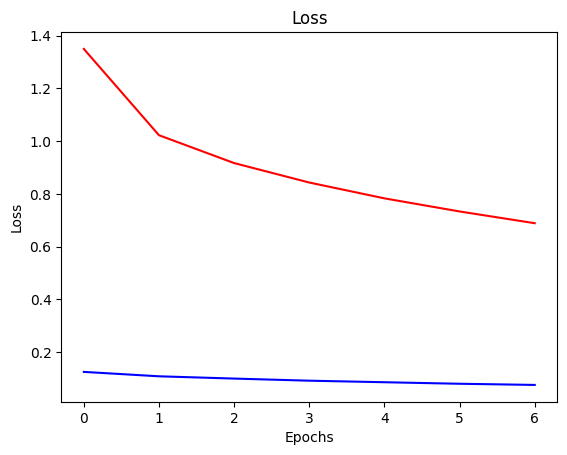

In [26]:
plt.plot(loss_plot, color='red')
plt.plot(val_loss_plot, color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.show()

In [27]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(bs=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = feature_extractor(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> the man is hiking up a grassy mountainside <end>
Prediction Caption: a man standing on a ropes <end>


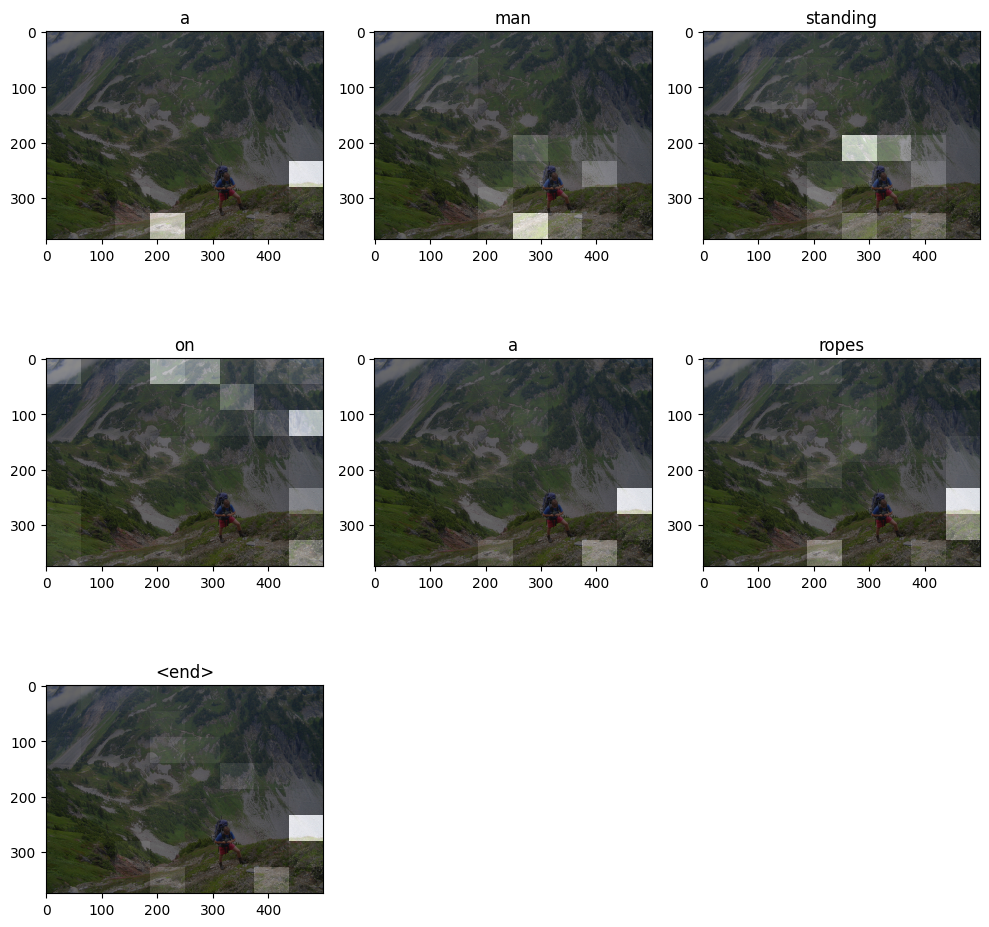

In [28]:
rid = np.random.randint(0, len(val_data))
image = val_data[rid]

real_caption = ' '.join([tokenizer.index_word[i] for i in val_captions[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [29]:
real_captions = []
generated_captions = []
img_path = []

n_tests = 300

for i,image in enumerate(test_data[:n_tests]):
  real_captions.append(' '.join([tokenizer.index_word[i] for i in test_captions[i] if i not in [0]]))
  caption, attention_plot = evaluate(image)
  img_path.append(image)
  generated_captions.append(caption)
  if i % 100 == 0: print("Describing id %d" %(i)) 

Describing id 0
Describing id 100
Describing id 200


NotFoundError: ignored

In [ ]:
warnings.filterwarnings('ignore')
tokenized_real_captions = []
tokenized_generated_captions = []
for caption in generated_captions:
  d_caption = caption[:len(caption)-1]
  tokenized_generated_captions.append(d_caption)

for caption in real_captions:
  back_caption = caption
  back_caption = back_caption.split()
  back_caption = back_caption[1:-1]
  tokenized_real_captions.append(back_caption)

pred_good, pred_bad, bleus, meteors = [], [], [], []
for i, path in enumerate(img_path):
  caption_true = tokenized_real_captions[i]
  gen_caption = tokenized_generated_captions[i]
  bleu = sentence_bleu([caption_true], gen_caption)
  bleus.append(bleu)
  if bleu > 0.7:
    pred_good.append((bleu,path,caption_true,gen_caption))
  elif bleu < 0.3:
    pred_bad.append((bleu,path,caption_true,gen_caption))

sns.set(color_codes = True)
sns.distplot(bleus)

print("\t\t\t BLEU")
print("BLEU higher: ", np.amax(bleus))
print("BLEU lower: ", np.amin(bleus))
print("Mean BLEU Score {:4.3f}".format(np.mean(bleus)))

In [ ]:
def plot_images(generated_captions):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(generated_captions)
    for pb in generated_captions:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"Caption:" + caption_true,fontsize=20)
        ax.text(0,0.4,"Generated:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Captions")
plot_images(pred_bad[:5])
print("Good Captions")
plot_images(pred_good[:5])

Base Model

In [ ]:
class Base_CNN_Encoder(tf.keras.Model):
    def __init__(self, dimension):
        super(Base_CNN_Encoder, self).__init__()
        self.cnn = tf.keras.applications.InceptionV3(include_top=False,
                                                     weights='imagenet')
        self.cnn.trainable = False
        self.reshape = tf.keras.layers.Reshape((64, 2048))

    def call(self, x):
        x = self.cnn(x)
        x = self.reshape(x)
        return x

class Base_RNN_Decoder(tf.keras.Model):
    def __init__(self, dimension, units, vocab_size):
        super(Base_RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, dimension)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

    def call(self, x, features, hidden):
        x = self.embedding(x)
        x = tf.concat([tf.expand_dims(features, 1), x], axis=-1)
        output, state = self.gru(x)
        x = self.fc1(output)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.fc2(x)

        return x, state

    def reset_state(self, bs):
        return tf.zeros((bs, self.units))




In [ ]:
dimension = 256

base_encoder = Base_CNN_Encoder(dimension)
base_decoder = Base_RNN_Decoder(dimension, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


In [ ]:
@tf.function
def base_training(img_tensor, target):
  loss = 0
  hidden = base_decoder.reset_state(bs=target.shape[0])
  d_ip = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = base_encoder(img_tensor)

      for i in range(1, target.shape[1]):
          predictions, hidden, _ = base_decoder(d_ip, features, hidden)

          loss += loss_function(target[:, i], predictions)

          d_ip = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = base_encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
loss_plot = []
val_loss_plot = []
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0
    val_total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(ds):
        batch_loss, t_loss = training(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    loss_plot.append(total_loss / num_steps)

    for (batch, (img_tensor, target)) in enumerate(val_ds):
        val_batch_loss, val_t_loss = training(img_tensor, target)
        val_total_loss += val_t_loss
        if batch % 100 == 0:
            print('Val_Loss {:.4f}'.format(val_batch_loss.numpy() / int(target.shape[1])))
    val_loss_plot.append(val_total_loss / num_steps)

    if epoch % 5 == 0:
      manage_checkpoint.save()

    print ('Epoch {} Loss {:.6f} Val_Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps, val_total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [ ]:
plt.plot(loss_plot, color='red', label='Training Loss')
plt.plot(val_loss_plot, color='blue', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
feature_extractor = tf.keras.applications.InceptionV3(
    include_top=False,
    weights='imagenet',
    input_shape=(3)  # Change this to match your input tensor shape
)

In [ ]:
def evaluate_basemodel(image):

    hidden = base_decoder.reset_state(bs=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = base_encoder(temp_input)

    features = feature_extractor(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = base_decoder(dec_input, features, hidden)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result


In [ ]:

real_captions = []
generated_captions = []
img_path = []

n_tests = 300

for i,image in enumerate(val_data[:n_tests]):
  real_captions.append(' '.join([tokenizer.index_word[i] for i in val_captions[i] if i not in [0]]))
  caption = evaluate_basemodel(image)
  img_path.append(image)
  generated_captions.append(caption)
  if i % 100 == 0: print("Describing id %d" %(i)) 

In [ ]:
warnings.filterwarnings('ignore')
tokenized_real_captions = []
tokenized_generated_captions = []
for caption in generated_captions:
  d_caption = caption[:len(caption)-1]
  tokenized_generated_captions.append(d_caption)

for caption in real_captions:
  back_caption = caption
  back_caption = back_caption.split()
  back_caption = back_caption[1:-1]
  tokenized_real_captions.append(back_caption)

pred_good, pred_bad, bleus, meteors = [], [], [], []
for i, path in enumerate(img_path):
  caption_true = tokenized_real_captions[i]
  gen_caption = tokenized_generated_captions[i]
  bleu = sentence_bleu([caption_true], gen_caption)
  bleus.append(bleu)
  if bleu > 0.7:
    pred_good.append((bleu,path,caption_true,gen_caption))
  elif bleu < 0.3:
    pred_bad.append((bleu,path,caption_true,gen_caption))

sns.set(color_codes = True)
sns.distplot(bleus)

print("\t\t\t BLEU")
print("BLEU higher: ", np.amax(bleus))
print("BLEU lower: ", np.amin(bleus))
print("BLEU Scores {:4.3f}".format(bleus))